In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os

### The schematic below offers an explanation of the different aspects of a CNN. See [this notebook](https://github.com/llSourcell/Convolutional_neural_network/blob/master/convolutional_network_tutorial.ipynb) for more info
 

![alt text](https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1497876372993.jpg)

### The image below is an example of how convolved features are extracted from 2D image data. 

### In our case we use 1D DNA sequence.

![alt text](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/more_images/Convolution_schematic.gif) 

## Lets try to apply a CNN to find the bases that are important for classifying WRKY18 peaks

### The expected motifs have been indiependently verified See the [DAP-seq website](http://neomorph.salk.edu/dap_web/pages/browse_table_aj.php) and also Fig. 1 from [this paper](https://www.pnas.org/content/111/6/2367)

##### The WRKY18 motif (from DAP-seq site)

![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo_rc1.png)
##### and it's reverse complement
![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo1.png)

##### The WRKY45 motifs (from https://www.pnas.org/content/111/6/2367)
![WRKY45 motif](data/wrky_motifs.png)

In [2]:
#rplace this with the output of the shell scriptget_training_data.sh
datafile = "./data/WRKY18_50bp_top1000.tsv"

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np
df=pd.read_csv(datafile, sep="\t", header=None, names=['id', 'sequence', 'label'])
df.head()
labels = list(str(string) for string in df.label)
sequences = list(str(string) for string in df.sequence)
one_hot_encoder = OneHotEncoder(n_values=2)
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

In [4]:
print("--- first 10 labels (negative) --- \n", input_labels[:9].T)
print("--- first 10 labels (positive) --- \n", input_labels[-10:-1].T)

--- first 10 labels (negative) --- 
 [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
--- first 10 labels (positive) --- 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [5]:
print(" --- raw sequence example --- ")
sequences[-4:-1]

 --- raw sequence example --- 


['AGGAGTACTTAAGATAAAGATGTTGACTTTTTCTTGTAGCGAAGAGAATG',
 'ATAGACCAAGATATTCAAATGCTTGACTTTTCCAGTTTTGGCAAGACTTC',
 'TGACGAGTTTAGTCTTATTACGACGACTTTCAATTGGGTCTGTATTGACT']

In [6]:
print("number of sequences: " + str(len(sequences)))
print("length of sequences: " + str(len(sequences[100])))

number of sequences: 1996
length of sequences: 50


In [7]:
# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(n_values=4)   
input_features = []  

for sequence in sequences:
    try:
        integer_encoded = integer_encoder.fit_transform(list(sequence))
        integer_encoded = np.array(integer_encoded).reshape(-1, 1)
        one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
        input_features.append(one_hot_encoded.toarray())
    except ValueError:
            print(sequence)
            continue 
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)


In [8]:
# print(input_features[:2])
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0])
print('One hot encoding of Label #1:\n',input_labels[0])

# print(input_features[:2])
print("Example sequence\n-----------------------")
print('DNA Sequence #1005:\n',sequences[1004][:10],'...',sequences[1004][-10:])
print('One hot encoding of Sequence #1005:\n',input_features[1004])
print('One hot encoding of Label #1005:\n',input_labels[1004])

Example sequence
-----------------------
DNA Sequence #1:
 TTACTTTCCT ... CCTTTCACTC
One hot encoding of Sequence #1:
 [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
One hot encoding of Label #1:
 [1. 0.]
Example sequence
-----------------------
DNA Sequence #1005:
 AGAAGCTGAC ... TCGTTGACGT
One hot encoding of Sequence #1005:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
One hot encoding of Label #1005:
 [0. 1.]


In [9]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

train_features.shape

(1497, 50, 4)

In [10]:
test_features[:1]

array([[[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]]])

In [11]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))

model.add(MaxPooling1D(pool_size=4))x
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])

model.summary()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 32)            1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4624      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


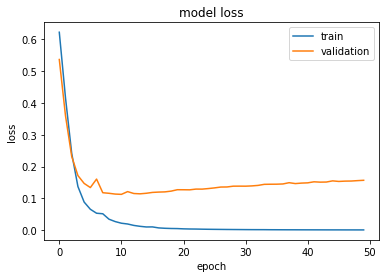

In [12]:
import matplotlib.pyplot as plt

history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

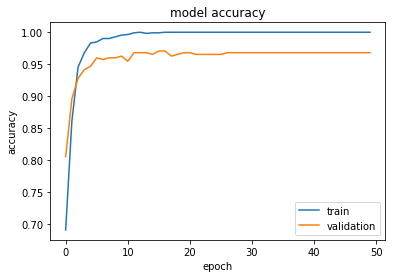

In [13]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[245   4]
 [  9 241]]


/global/homes/m/mmingay/.conda/envs/jupyter_env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


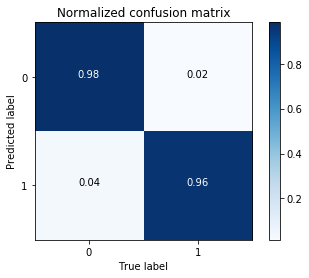

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1)
                      
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [20]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

The sequence index number below is the peak for which data will be plotted. 

In this example any sequence below 1000 is negative and any sequence between 1001-2000 will be positive

In [26]:
sequence_index = 1100  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.

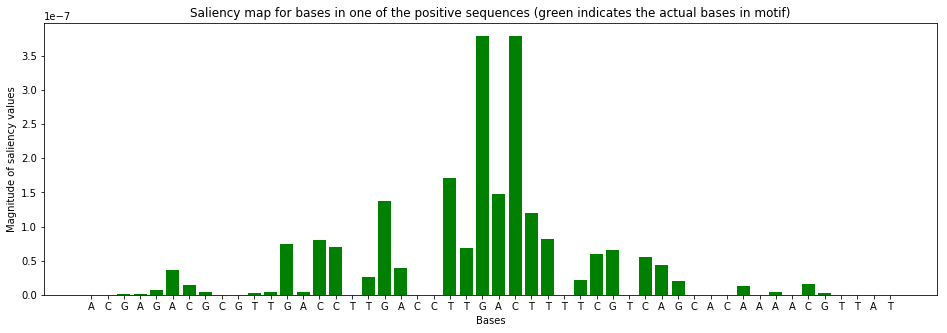

In [28]:
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal, color='g')
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');
plt.show()

#### The WRKY45 motif (from DAP-seq site) and it's reverse complement

![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY45_col_a/meme_out/logo1.png) ![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY45_col_a/meme_out/logo_rc1.png)

#### The WRKY18 motif (from DAP-seq site) and it's reverse complement


![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo_rc1.png) ![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo1.png)

#### The WRKY45 motifs (from [https://www.pnas.org/content/111/6/2367])
![WRKY45 motif](data/wrky_motifs.png)

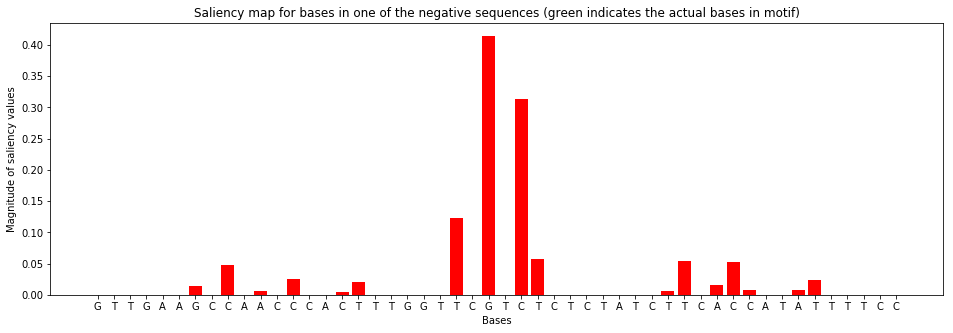

In [34]:
sequence_index = 400  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal, color='r')
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the negative sequences'
          ' (green indicates the actual bases in motif)');
plt.show()

### What is in the model?

In [37]:
model.output_shape

(None, 2)

#### Looks like the model is just putting out either [1,0] or [0,1] for positive and negative labels, resp.

In [44]:
model.get_weights()[1]

array([ 1.7504733e-02, -2.7279221e-02, -2.5017934e-02, -4.8118364e-03,
        1.4496816e-02, -4.7639115e-03,  2.5166248e-03,  3.1125631e-02,
       -1.4330511e-02, -2.1938693e-03,  3.2211447e-03,  2.4471136e-03,
       -1.4651744e-02, -2.7646814e-02,  1.8133398e-02,  1.6446842e-02,
       -1.4724366e-02,  3.2393493e-02, -1.9779010e-02, -8.8661090e-03,
        3.9633237e-02,  3.0050566e-02, -2.5086483e-02,  4.5087431e-03,
       -6.5193877e-02,  4.7827201e-04, -4.0453104e-03,  5.6279446e-03,
        9.4268667e-03,  1.6956938e-02, -3.2778529e-03, -2.1057804e-05],
      dtype=float32)

In [45]:
model.get_weights()[1].shape

(32,)

In [46]:
print("there are " + str(len(model.get_weights()[1])) + " weights....")

there are 32 weights....


#### Looks like we have a weight for each of the filters from the first Conv1D layer

In [1]:
model.summary()

NameError: name 'model' is not defined